# Classifying Humorous Text from Yelp Reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast

In [2]:
# specify device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load & Clean Data

##### Download dataset from https://www.kaggle.com/yelp-dataset/yelp-dataset

## Split into Training, Validation, and Test Sets

#####  Run etl_1 and etl_2 before starting.


In [3]:
result = pd.read_csv("./data/yelp_reduced.csv")
result.shape

(400, 9)

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(result.text, 
                                                    result.humor, 
                                                    test_size=0.3, 
                                                    random_state=8, 
                                                    stratify=result.humor)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                                random_state=8, 
                                                test_size=0.5, 
                                                stratify=y_temp)

## Import Model and Tokenizer

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-cased')

MODEL_TYPE = 'bert-base-cased'

tokenizer = BertTokenizerFast.from_pretrained(MODEL_TYPE)

## Tokenization

In [6]:
# Rest of the notebook is adapted from 
# https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb

<AxesSubplot:>

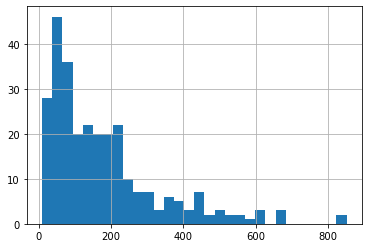

In [7]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)

In [8]:
max_seq_len = 400

In [9]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

## Convert to Tensors

In [10]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

## Create DataLoaders

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## Freeze BERT Parameters

In [12]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Model Architecture

In [13]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)

      return x

In [14]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [15]:
# optimizer from hugging face transformers
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-3)

## Get Weights

In [16]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

print(class_wts)

[1. 1.]


In [17]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 10

## Fine-tune BERT

In [18]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [19]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## Train Model

In [20]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.806
Validation Loss: 0.711

 Epoch 2 / 10

Evaluating...

Training Loss: 0.659
Validation Loss: 0.653

 Epoch 3 / 10

Evaluating...

Training Loss: 0.628
Validation Loss: 0.651

 Epoch 4 / 10

Evaluating...

Training Loss: 0.630
Validation Loss: 0.631

 Epoch 5 / 10

Evaluating...

Training Loss: 0.613
Validation Loss: 0.713

 Epoch 6 / 10

Evaluating...

Training Loss: 0.715
Validation Loss: 0.806

 Epoch 7 / 10

Evaluating...

Training Loss: 0.619
Validation Loss: 0.695

 Epoch 8 / 10

Evaluating...

Training Loss: 0.560
Validation Loss: 0.659

 Epoch 9 / 10

Evaluating...

Training Loss: 0.634
Validation Loss: 0.706

 Epoch 10 / 10

Evaluating...

Training Loss: 0.634
Validation Loss: 0.895


## Load Model 

In [21]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Test Model

In [22]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [23]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.72      0.60      0.65        30
           1       0.66      0.77      0.71        30

    accuracy                           0.68        60
   macro avg       0.69      0.68      0.68        60
weighted avg       0.69      0.68      0.68        60



In [24]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,18,12
1,7,23


In [25]:
# # taking the raw outputs of the stacked encoders of BERT, and attaching their own specific model to it, most commonly 
# # a linear layer, and then fine-tuning this model on their specific dataset

# from transformers import BertModel

# class Bert_Model(nn.Module):
#    def __init__(self, class):
#        super(Bert_Model, self).__init__()
#        self.bert = BertModel.from_pretrained('bert-base-uncased')
#        self.out = nn.Linear(self.bert.config.hidden_size, classes)
#        self.sigmoid = nn.Sigmoid()
#    def forward(self, input):
#        _, output = self.bert(**input)
#        out = self.out(output)
#        return out